In [1]:
import path_setup
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle
from script.utils import save_if_better

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials


In [3]:
sweep_config = {
        'fc_layer_size': 512,
        'decoder_layer_size': 128,
        'encoder_epochs': 5,
        'decoder_epochs': 20,
        'patience': 3,
        'latent_size': 128,
        'spectrogram_size': 500,
        'encoder_learning_rate': 1e-5,
        'decoder_learning_rate': 5e-5,
        'batch_size': 64,
        'temperature': 0.606,
        'time_bins': 16,
        'library': 'librosa'
    }

folder_path = "/scratch/th3129/region_decoding/results"
session_config = {
    "separate": True,
    "visualize": True,
    'swr_flag': False,
    't_starts': np.arange(2160, 2340, 3),
    'within_session': True,
    'supervised_contrastive': False,
    'sampling_rate': 20000,
    'trial_length': 3,
    'session_idx': True
}

sessions = ["AD_HF01_1", "AD_HF02_2", "AD_HF02_4", "AD_HF03_1", "AD_HF03_2", "NN_syn_01", "NN_syn_02"]

In [4]:
pickle_path = f'/scratch/cl7201/shared/Neuronexus/spectrogram'
output_path = f"results/Neuronexus/spectrogram/SimCLR_MLP"
i = 0

In [5]:
print("Preprocessing data...")
channel_features_all, channel_labels_all, channel_trials_all = load_preprocessed_data(pickle_path, sessions)

Preprocessing data...


In [6]:
print("Training model on source session...")
idx_train, idx_test = train_test_split(range(len(session_config['t_starts'])), test_size=0.2, random_state=66)
idx_train, idx_val = train_test_split(idx_train, test_size=0.25, random_state=66)
indices = idx_train, idx_val, idx_test
accuracy_scores, f1_scores = [], []

group = "within_session" if session_config["within_session"] else "across_session"
data_size = len(session_config["t_starts"])

Training model on source session...


/scratch/th3129/region_decoding/blind_localization/data/datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshaped_data = torch.tensor(reshaped_data, dtype=torch.float32)
/scratch/th3129/region_decoding/blind_localization/data/datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshaped_data = torch.tensor(reshaped_data, dtype=torch.float32)
/scratch/th3129/region_decoding/blind_localization/data/datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshaped_data = torch.tensor(reshaped_data, dtype=torch.f

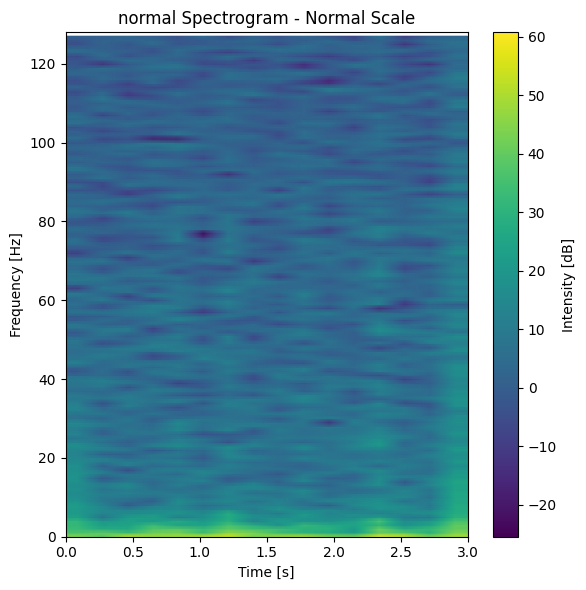

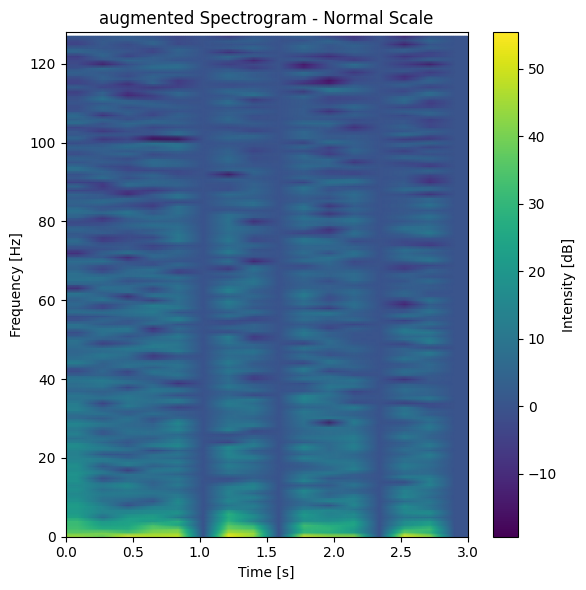

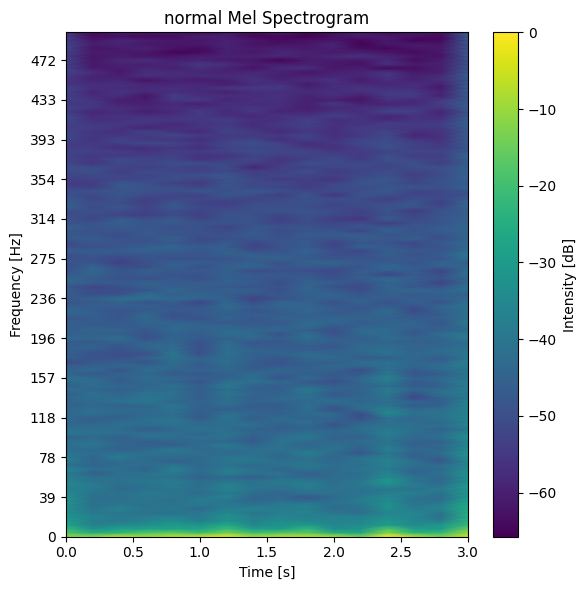

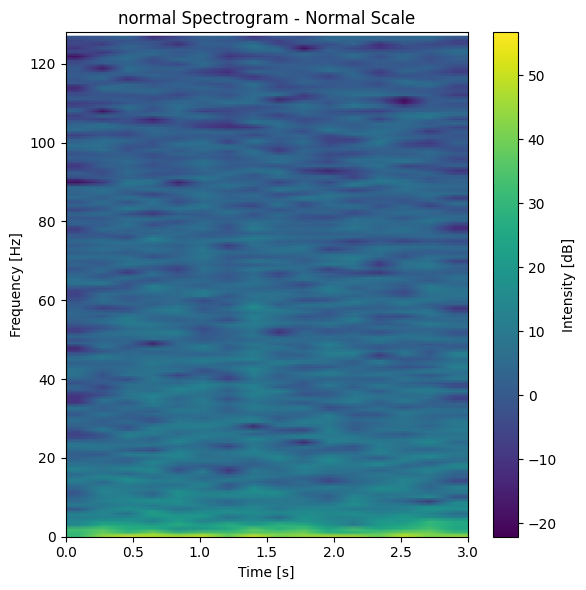

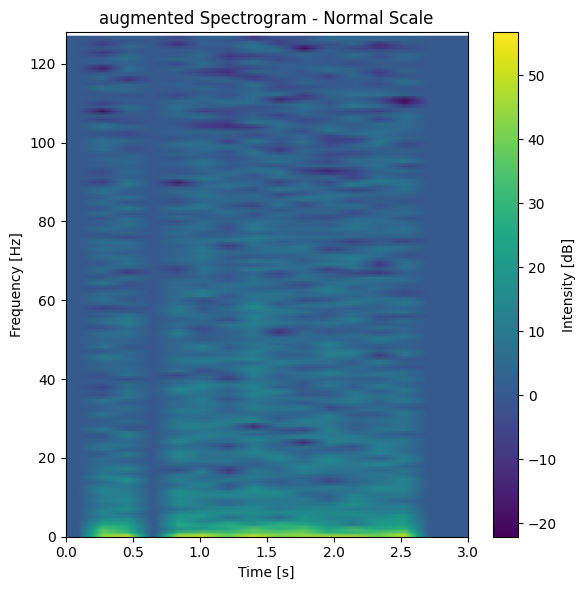

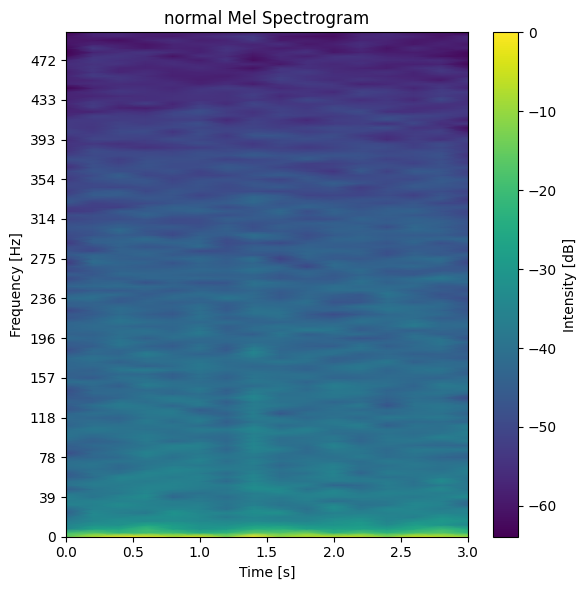

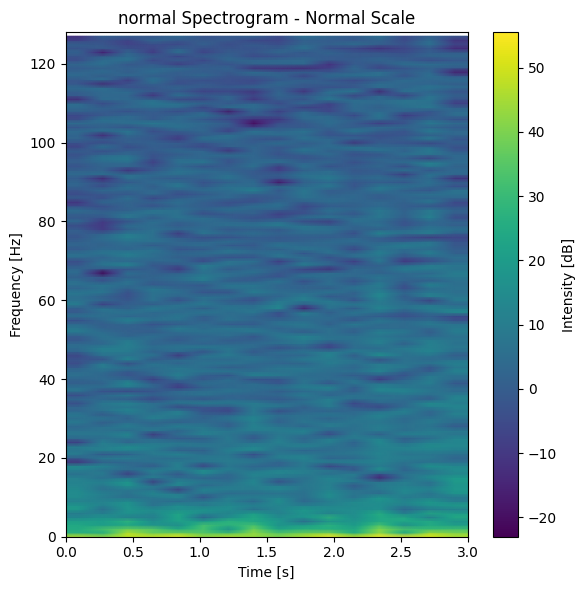

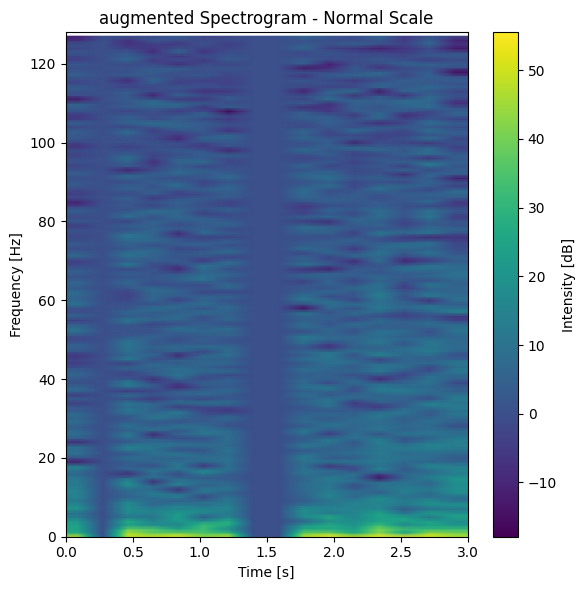

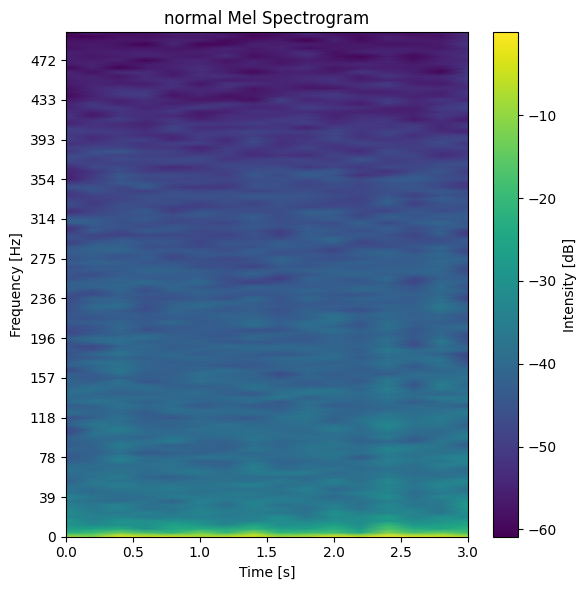

In [7]:
if session_config['within_session']:
    train_dataloader, val_dataloader, test_dataloader = build_single_session_dataloader(channel_features_all,
                                                                                        channel_labels_all,
                                                                                        channel_trials_all,
                                                                                        sweep_config,
                                                                                        RawDataset, sessions,
                                                                                        session_idx=i, vit=True)
else:
    train_dataloader, val_dataloader, test_dataloader = build_multi_session_dataloader(channel_features_all,
                                                                                        channel_labels_all,
                                                                                        channel_trials_all,
                                                                                        sessions,
                                                                                        sweep_config, RawDataset,
                                                                                        test_session_idx=i, vit=True)


In [8]:
def train(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()
    total_loss = []

    for data, label in tqdm(dataloader):
        spectrograms, augmented_spectrograms = data
        spectrograms: torch.Tensor = spectrograms
        augmented_spectrograms: torch.Tensor = augmented_spectrograms
        label: torch.Tensor = label

        spectrograms = spectrograms.to(device)
        augmented_spectrograms = augmented_spectrograms.to(device)
        label = label.to(device)
        # print(optimizer.state_dict())
        optimizer.zero_grad()
        # print(optimizer.param_groups[-1]['lr'])
        # print(optimizer.state_dict())

        z_i = model(spectrograms)
        z_j = model(augmented_spectrograms)

        # for name, param in model.named_parameters():
        #     if param.requires_grad:  # Only print trainable parameters
        #         print(f"{name} - Min: {param.data.min().item()}, Max: {param.data.max().item()}, NaN: {torch.isnan(param.data).any().item()}")

        loss: torch.Tensor = criterion(z_i, z_j)
        loss.backward()

        # grad = {}
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: Gradient min: {param.grad.min().item()}, max: {param.grad.max().item()}")
        #         grad[name] = (param.grad.min().item(), param.grad.max().item())
        #     else:
        #         print(f"{name}: Gradient is NaN")
                
        optimizer.step()

        # for name, param in model.named_parameters():
        #     if param.requires_grad:  # Only print trainable parameters
        #         print(f"{name} - Min: {param.data.min().item()}, Max: {param.data.max().item()}, NaN: {torch.isnan(param.data).any().item()}")

        total_loss.append(loss.item())

        # plot_grads(grad)
    
    avg_loss = sum(total_loss) / len(total_loss)
    return avg_loss

In [9]:
def plot_grads(grad):
    layer_names = list(grad.keys())
    layer_names = ['.'.join(x.split('.')[2:]) for x in layer_names]
    min_grad = [g[0] for g in grad.values()]
    max_grad = [g[1] for g in grad.values()]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(layer_names)), min_grad, label='Min Gradient', marker='o')
    plt.scatter(range(len(layer_names)), max_grad, label='Max Gradient', marker='x')
    plt.xticks(range(len(layer_names)), layer_names, rotation=90, fontsize=5)
    plt.xlabel("Layers")
    plt.ylabel("Gradient Value")
    plt.title("Gradient Min and Max per Layer")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
from transformers import ASTForAudioClassification, AutoConfig

class ViTEncoder(nn.Module):
    def __init__(self, input_size, output_size, use_projector=False, pretrained=True, freq_bins=500):
        super(ViTEncoder, self).__init__()

        # config = AutoConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        # self.vit = ASTForAudioClassification(config=config)
        self.vit = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", attn_implementation="sdpa", torch_dtype=torch.float16)
        self.vit.classifier = nn.Identity()
        
        self.use_projector = use_projector
        hidden_dim = self.vit.audio_spectrogram_transformer.layernorm.normalized_shape[0]
        # self.vit.audio_spectrogram_transformer.layernorm = nn.Identity()

        # n_layers = len(self.vit.audio_spectrogram_transformer.encoder.layer)
        # for i in range(n_layers):
        #     self.vit.audio_spectrogram_transformer.encoder.layer[i].layernorm_before = nn.Identity()
        #     self.vit.audio_spectrogram_transformer.encoder.layer[i].layernorm_after = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        ).half()

        print(self.vit)

        self.feature_adjust = nn.Linear(hidden_dim, output_size).half()
        self.freq_bins = freq_bins

    def forward(self, x):        
        x = (x - x.mean(dim=(1, 2), keepdim=True)) / (x.std(dim=(1, 2), keepdim=True)) / 2
        x = x.half()
        x = self.vit(x).logits

        # print(f"Input min: {x.min().item()}, max: {x.max().item()}, NaN: {torch.isnan(x).any()}")

        # x = self.vit.audio_spectrogram_transformer.embeddings(x)
        # print(f"After embeddings min: {x.min().item()}, max: {x.max().item()}, NaN: {torch.isnan(x).any()}")
        # x.register_hook(lambda grad: print(f"Grad After embeddings min={grad.min()}, max={grad.max()}, NaN={torch.isnan(grad).any()}"))

        # x = self.vit.audio_spectrogram_transformer.encoder(x).last_hidden_state
        # print(f"After encoder min: {x.min().item()}, max: {x.max().item()}, NaN: {torch.isnan(x).any()}")
        # x.register_hook(lambda grad: print(f"Grad After encoder min={grad.min()}, max={grad.max()}, NaN={torch.isnan(grad).any()}"))

        # x = self.vit.audio_spectrogram_transformer.layernorm(x)
        # print(f"After layernorm min: {x.min().item()}, max: {x.max().item()}, NaN: {torch.isnan(x).any()}")
        # x.register_hook(lambda grad: print(f"Grad After layernorm min={grad.min()}, max={grad.max()}, NaN={torch.isnan(grad).any()}"))

        # x = x.mean(dim=1)
        # print(f"Logits min: {x.min().item()}, max: {x.max().item()}")

        if self.use_projector:
            x = self.projector(x)
        else:
            x = self.feature_adjust(x)

        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = train_dataloader.dataset[0][0][0].size()[0]
# torch.autograd.set_detect_anomaly(True)
encoder = ViTEncoder(input_size=sweep_config['latent_size'], output_size=sweep_config['latent_size'], use_projector=True, pretrained=True)
model = ContrastiveLearningWithMLP(encoder, input_dim=sweep_config['latent_size'], hidden_dim=sweep_config['decoder_layer_size'], output_dim=5).to(device)

# def forward_hook(module, input, output):
#     # Calculate min, max, and check for NaN
#     min_val = output.min().item() if torch.is_tensor(output) else None
#     max_val = output.max().item() if torch.is_tensor(output) else None
#     has_nan = torch.isnan(output).any().item() if torch.is_tensor(output) else False
#     print(f"{module}: Min: {min_val}, Max: {max_val}, NaN: {has_nan}")

# for name, module in model.named_modules():
#     if "embeddings" in name:  # Target layers by name
#         module.register_forward_hook(forward_hook)

contrastive_criterion = InfoNCELoss(temperature=sweep_config['temperature'], device=device)
supervised_criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=sweep_config["encoder_learning_rate"], eps=1e-6)
combined_optimizer = optim.Adam(model.parameters(), lr=sweep_config["decoder_learning_rate"])
best_decoder_loss = 10000
patience_counter = 0

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [12]:
for epoch in range(sweep_config["encoder_epochs"]):
    train_loss = train(model.encoder, train_dataloader, encoder_optimizer, contrastive_criterion, device)
    val_loss = validation(model.encoder, val_dataloader, contrastive_criterion, device)
    
    print(f'Epoch [{epoch+1}/{sweep_config["encoder_epochs"]}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

100%|██████████| 364/364 [04:07<00:00,  1.47it/s]


Epoch [1/5], Train Loss: 4.8434, Val Loss: 4.8341


100%|██████████| 364/364 [04:02<00:00,  1.50it/s]


Epoch [2/5], Train Loss: 4.8435, Val Loss: 4.8341


100%|██████████| 364/364 [04:00<00:00,  1.51it/s]


Epoch [3/5], Train Loss: 4.8436, Val Loss: 4.8341


100%|██████████| 364/364 [04:00<00:00,  1.51it/s]


Epoch [4/5], Train Loss: 4.8436, Val Loss: 4.8341


100%|██████████| 364/364 [04:02<00:00,  1.50it/s]


Epoch [5/5], Train Loss: 4.8436, Val Loss: 4.8341
